In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

In [43]:
# Crate 1D Data into Time-Series
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

#Load Dataset
df = pd.read_csv("/Users/zhouwenbin/Documents/crypto/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv")
df = df.rename(columns={"Timestamp":"date"})
df["date"] = pd.to_datetime(df["date"],unit="s")

#get rid of the null data
df = df.dropna()

#select time period, in this example we selected half year data
df=df[(df['date'] >='2019-05-01 00:00:00') & (df['date'] <= '2019-12-01 23:59:00')]


In [44]:
df = df.reindex(index= df.index[::-1])#reverse order of date

In [45]:
zaman = np.arange(1, len(df) + 1, 1)
price = df["Weighted_Price"]

In [46]:
price = np.reshape(price.values, (len(price),1))
scaler = MinMaxScaler(feature_range=(0,1))
price = scaler.fit_transform(price)

In [47]:
train_price = int(len(price)*0.56)
test_price = len(price) - train_price
train_price, test_price = price[0:train_price,:], price[train_price:len(price),:]

In [48]:
trainX, trainY = new_dataset(train_price,1)
testX, testY = new_dataset(test_price,1)

# Reshape dataset for LSTM in 3D Dimension
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))
step_size = 1

In [85]:
# trainX[0]
trainY[0,0]

7404.599514

In [87]:
trainX[0,0]

array([0.25012228])

In [49]:
# LSTM Model is created
model = Sequential()
model.add(LSTM(128, input_shape=(1, step_size)))
model.add(Dropout(0.1))
# model.add(LSTM(64))
# model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
#train model
#Increase epochs to 10 will reduce loss, however  5 is already in good performance
model.fit(trainX, trainY, epochs=2, batch_size=25, verbose=2)

Epoch 1/2
 - 17s - loss: 0.0011
Epoch 2/2
 - 17s - loss: 4.4421e-05


In [51]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-Normalizing for plotting 
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Performance Measure RMSE is calculated for predicted train dataset
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Train RMSE: %.2f" % (trainScore))

# Performance Measure RMSE is calculated for predicted test dataset
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Test RMSE: %.2f" % (testScore))

# Converted predicted train dataset for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size,:] = trainPredict

# Converted predicted test dataset for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(price)-1,:] = testPredict


# Finally predicted values are visualized


Train RMSE: 14.45
Test RMSE: 17.20


In [52]:
price = scaler.inverse_transform(price)

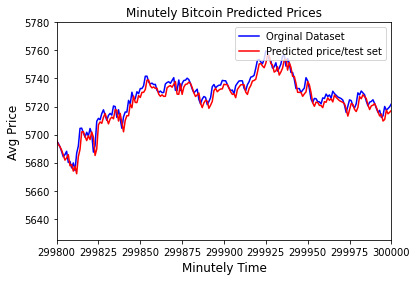

In [71]:

plt.plot(price, 'b', label='Orginal Dataset')
# plt.plot(trainPredictPlot, 'r', label='Training Set')
plt.plot(testPredictPlot, 'r', label='Predicted price/test set')
plt.title("Minutely Bitcoin Predicted Prices")
plt.xlim(299800, 300000)
plt.ylim(5625,5780)
plt.xlabel('Minutely Time', fontsize=12)
plt.ylabel('Avg Price', fontsize=12)
plt.legend(loc='upper right')
plt.show()